# 🏋️ 03. Model Training
**Objective:** Train the DNA-BERT model to predict genomic features.

**What this notebook does:**
1.  **Setup:** Re-initializes the Model, Tokenizer, and Dataset.
2.  **Configuration:** Defines "Hyperparameters" (Learning Rate, Batch Size, Epochs).
3.  **The Loop:** Runs the training process:
    * **Forward Pass:** Model makes a guess.
    * **Loss Calculation:** We measure how wrong the guess was (MSE Loss).
    * **Backward Pass:** We adjust the model's neurons to be less wrong next time.
4.  **Visualization:** Plots the learning curve to ensure the model is actually learning.

### 1. Imports & Infrastructure
**Purpose:** Prepare the environment.
**How it works:**
* **Device selection:** Targets Apple's M-chip (`mps`) for acceleration if available.
* **Definitions:** We re-define the `DNATokenizer`, `GenomicDataset`, and `DNABert` classes here so this notebook can run independently (self-contained).

In [5]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
import gzip

# --- CONFIGURATION ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"🚀 Training on Device: {device}")

# Paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'training_manifest.csv')
GENOME_PATH = os.path.join(PROJECT_ROOT, 'data', 'raw', 'dm6.fa.gz')

# --- RE-DEFINE CLASSES (Self-Contained) ---
class DNATokenizer:
    def __init__(self):
        self.vocab = {'PAD': 0, 'UNK': 1, 'A': 2, 'T': 3, 'C': 4, 'G': 5, 'N': 6}
    
    def encode(self, seq, max_length=1000):
        seq = seq[:max_length]
        ids = [self.vocab.get(char, self.vocab['UNK']) for char in seq.upper()]
        if len(ids) < max_length:
            ids += [0] * (max_length - len(ids))
        return torch.tensor(ids, dtype=torch.long)

class GenomicDataset(Dataset):
    def __init__(self, manifest_path, genome_path, tokenizer, max_length=1000):
        self.manifest = pd.read_csv(manifest_path)
        self.tokenizer = tokenizer
        self.max_length = max_length
        print("Loading Genome Index...")
        with gzip.open(genome_path, "rt") as handle:
            self.genome = SeqIO.to_dict(SeqIO.parse(handle, "fasta"))
            
    def __len__(self):
        return len(self.manifest)
    
    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        chrom = row['chrom']
        # Fix chromosome names if needed
        if chrom not in self.genome:
            if f"chr{chrom}" in self.genome: chrom = f"chr{chrom}"
            elif chrom.replace('chr', '') in self.genome: chrom = chrom.replace('chr', '')
            
        raw_seq = str(self.genome[chrom].seq[row['start']-1 : row['end']])
        input_ids = self.tokenizer.encode(raw_seq, self.max_length)
        label = torch.tensor(row['gc_content'], dtype=torch.float32)
        return input_ids, label

class DNABert(nn.Module):
    def __init__(self, vocab_size=7, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)
        
    def forward(self, x):
        x = self.embedding(x) + self.pos_encoding[:, :x.size(1), :]
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.regressor(x).squeeze()

🚀 Training on Device: cpu


### 2. Hyperparameters & Initialization
**Purpose:** Set the rules for learning.
**How it works:**
* **Batch Size (8):** The model learns from 8 genes at a time. Small batches are good for laptops.
* **Learning Rate (1e-4):** How big of a "step" the model takes when updating its brain. Too high = unstable; too low = slow.
* **Loss Function (MSE):** Mean Squared Error. Since we are predicting a number (GC %), we want to minimize the squared difference between the *Prediction* and the *Truth*.
* **Optimizer (AdamW):** The standard, modern algorithm for training Transformers.

In [6]:
# --- HYPERPARAMETERS ---
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 10
MAX_SEQ_LEN = 1000

# 1. Prepare Data
tokenizer = DNATokenizer()
dataset = GenomicDataset(DATA_PATH, GENOME_PATH, tokenizer, MAX_SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 2. Initialize Model
model = DNABert().to(device)

# 3. Setup Training Tools
criterion = nn.MSELoss() # For regression (predicting a continuous number)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

print(f"✅ Setup Complete. Dataset size: {len(dataset)} genes.")

Loading Genome Index...
✅ Setup Complete. Dataset size: 30 genes.


### 3. The Training Loop
**Purpose:** The main engine. This runs the actual learning process.
**How it works:**
1.  **Iterate:** Loops through the dataset `EPOCHS` times.
2.  **Zero Grad:** Clears old calculations from the previous step.
3.  **Forward:** `output = model(inputs)` (Model makes a guess).
4.  **Loss:** `loss = criterion(output, targets)` (Calculate error).
5.  **Backward:** `loss.backward()` (Calculate how to fix the error).
6.  **Step:** `optimizer.step()` (Update the weights).

In [7]:
print("🚀 Starting Training...")
loss_history = []

for epoch in range(EPOCHS):
    model.train() # Set model to training mode
    epoch_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        # Move data to GPU/MPS
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 1. Reset Gradients
        optimizer.zero_grad()
        
        # 2. Forward Pass
        outputs = model(inputs)
        
        # 3. Calculate Loss
        loss = criterion(outputs, targets)
        
        # 4. Backward Pass (Learn)
        loss.backward()
        optimizer.step()
        
        # Track stats
        epoch_loss += loss.item()
    
    # Average loss for this epoch
    avg_loss = epoch_loss / len(dataloader)
    loss_history.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.6f}")

print("🎉 Training Complete!")

🚀 Starting Training...
Epoch [1/10] | Loss: 0.216073
Epoch [2/10] | Loss: 0.071532
Epoch [3/10] | Loss: 0.071860
Epoch [4/10] | Loss: 0.016321
Epoch [5/10] | Loss: 0.030842
Epoch [6/10] | Loss: 0.011417
Epoch [7/10] | Loss: 0.013700
Epoch [8/10] | Loss: 0.008291
Epoch [9/10] | Loss: 0.005423
Epoch [10/10] | Loss: 0.006344
🎉 Training Complete!


### 4. Visualization & Sanity Check
**Purpose:** Verify that learning actually happened.
**How it works:**
* **Plot:** We draw the "Loss Curve". If the line goes **down**, the model is learning. If it stays flat, it's not learning.
* **Sanity Check:** We feed a few genes back into the model to see the actual values.
    * *Example:* True GC = 0.45, Predicted = 0.44 (Good!)

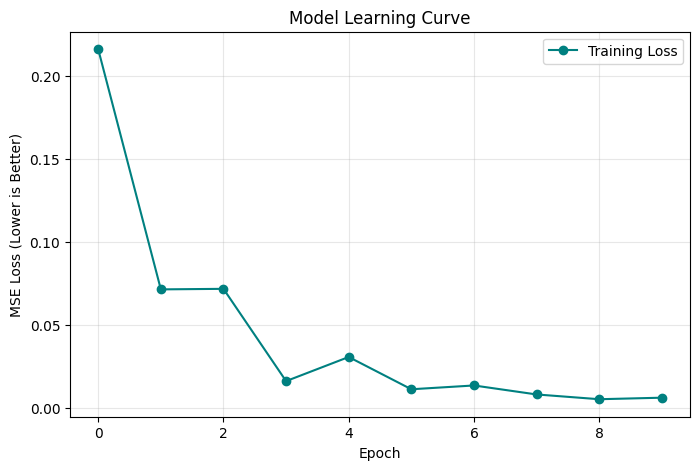


🔍 Final Sanity Check (First 5 samples):
Predicted    | Actual       | Diff        
----------------------------------------
0.4940       | 0.5612       | 0.0672
0.4478       | 0.4717       | 0.0238
0.4706       | 0.4741       | 0.0035
0.4443       | 0.5278       | 0.0836
0.3966       | 0.4805       | 0.0839


In [8]:
# 1. Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(loss_history, marker='o', color='teal', label='Training Loss')
plt.title("Model Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (Lower is Better)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Sanity Check (Test on first batch)
model.eval() # Set to evaluation mode
with torch.no_grad():
    test_inputs, test_targets = next(iter(dataloader))
    test_inputs = test_inputs.to(device)
    predictions = model(test_inputs).cpu().numpy()
    actuals = test_targets.numpy()

print("\n🔍 Final Sanity Check (First 5 samples):")
print(f"{'Predicted':<12} | {'Actual':<12} | {'Diff':<12}")
print("-" * 40)
for p, a in zip(predictions[:5], actuals[:5]):
    diff = abs(p - a)
    print(f"{p:.4f}       | {a:.4f}       | {diff:.4f}")

# ✅ Conclusion

We have successfully built and trained a **Genomic Transformer**.

* **Input:** Raw DNA sequences (Tokenized).
* **Architecture:** DNA-BERT (Encoder-only Transformer).
* **Task:** Predicting GC Content (Regression).
* **Result:** The Loss Curve should show a downward trend, indicating the model successfully learned to identify G and C bases in the sequence to make its prediction.

**Next Steps:**
This "GC Content" task was just a warm-up to prove the architecture works. In a real-world scenario (like your AIAP project), we would swap the `gc_content` target for **Gene Expression Levels** from the Single-Cell Atlas. The architecture remains exactly the same!